In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import sys
import csv
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import normalize
import torch.optim as optim

#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import plotly.figure_factory as ff
import plotly.io as pio


In [3]:
def preprocessing(mydf, threshold):    
    # Record start time
    df2=df.copy()

    df2=df2.dropna() #drop rows with nan numbers
    df2.replace([np.inf, -np.inf], 0, inplace=True) # replace inf with zero
    df2.columns[(df2 == 0).all()] # Check if there are any columns whose elements are all zeros
    df2=df2.loc[:, (df2 != 0).any(axis=0)]
    df2=df2.drop(['Flow ID', 'Timestamp', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port'], axis=1)
    df2=df2.drop(['Label.1'], axis=1)
    df2=df2.reset_index(drop=True)

    newdf = df2.drop(range(0,70000)).reset_index(drop=True)

    replicate = newdf.loc[50000:69999]
    replicated = pd.concat([newdf, replicate]).reset_index(drop=True)
    replicated = replicated.sample(frac=1).reset_index(drop=True)

    target2 = replicated.filter(['Label'], axis=1)

    replicated.loc[replicated['Label'] == 'Non-Tor', 'Label'] = 0
    replicated.loc[replicated['Label'] == 'NonVPN', 'Label'] = 0
    replicated.loc[replicated['Label'] == 'Tor', 'Label'] = 1
    replicated.loc[replicated['Label'] == 'VPN', 'Label'] = 1

    target = replicated.filter(['Label'], axis=1)


    target=target.to_numpy().astype(int).squeeze()
    encoder = LabelEncoder()
    encoder.fit(np.ravel(target))
    target = encoder.transform(np.ravel(target))
    target = 2 * target - 1 ################
    myfeature = replicated.drop(['Label'], axis=1)

    X = myfeature
    y = target

    lo_var_selector = VarianceThreshold(threshold)
    Xx_np = lo_var_selector.fit_transform(X)
    
    selected_feature_indices = lo_var_selector.get_support(indices=True)

    # Create a new DataFrame using the selected features and original column names
    selected_columns = X.columns[selected_feature_indices]
    Xx_df = pd.DataFrame(Xx_np, columns=selected_columns)
    
    return Xx_np, lo_var_selector, myfeature, y, Xx_df

def getRFParameter(rf_classifier):
    params = rf_classifier.get_params()
    for param, value in params.items():
        print(f"{param}: {value}")

def standardize_preprocessing(np_processed):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np_processed)
    return scaled_data
    
    
def searchRandomForest(estimator, X, y, df_feature):
    param_grid = {
        'n_estimators': [75, 100, 125],       # Number of trees in the forest
        'max_depth': [None, 5, 10, 15],          # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
        }
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    grid_search.fit(X_train, y_train)
    # Get the best hyperparameters from grid search
    best_params = grid_search.best_params_
    # Create a new RandomForestClassifier using the best hyperparameters
    best_rf_clf = RandomForestClassifier(**best_params)    
    best_rf_clf.fit(X_train, y_train)
    
    calc_result_rf = list(zip(df_feature, best_rf_clf.feature_importances_))
    calc_result_rf.sort(key = lambda x : x[1], reverse=True)
    
    np_feature_rf=df_feature.filter([calc_result_rf[s][0] for s in range(15)], axis=1)
    getRFParameter(best_rf_clf)
    return best_rf_clf, np_feature_rf

def getRandomForestFeature(estimator, yourfeaturedf, yourfeaturenp):
    calc_result_rf = list(zip(yourfeaturedf, estimator.feature_importances_))
    calc_result_rf.sort(key = lambda x : x[1], reverse=True)
    filename = "feature_selection_rf.csv"
    write_results_to_file_feature(calc_result_rf, filename)
    

class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        #self.fc4 = nn.Linear(32, output_size)
        self.linear = nn.Linear(input_size, output_size)
        #self.activation = nn.Sigmoid()
        self.activation = nn.Tanh()

    def forward(self, x):
        #x = torch.sigmoid(self.fc4(x))
        x = self.linear(x)
        x = self.activation(x)            
        return x
    
    
    
def write_results_to_file_feature(results, filename):
    with open(filename, "a", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)

        # Write header
        csv_writer.writerow(["Feature", "Rank"])

        # Write data
        csv_writer.writerows(results)
def read_csv_feature(filename):
    tuple_list = []

    # Read the CSV file and convert it to a list of tuples
    with open(filename, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)

        # Skip the header
        next(csv_reader)

        # Iterate through the rows and convert to tuple
        for row in csv_reader:
            tuple_list.append((row[0]))
    return tuple_list

In [4]:
def action_space_construction(mylist, best_rf_clf, num_feature, step_size, feature, label, df_feature):
    featurelist=list(df_feature.columns)
    for item in (mylist):
        para=item
        if (item=="recur" or item=="RFECV"):
            if (para=="recur"):
                selector = RFE(estimator=best_rf_clf, n_features_to_select=num_feature, step=step_size)
            elif (para=="RFECV"):
                selector = RFECV(estimator=best_rf_clf, step=step_size, cv=StratifiedKFold(3), scoring='accuracy')
            '''elif (para=="rf"):selector=best_rf_clf # vanilla random forest'''

        elif (para=="kbest"):
            selector = SelectKBest(score_func=mutual_info_classif, k=num_feature) # Select top k features
            #X_new = SelectKBest(chi2, k=20).fit_transform(X, y)

        else:
            print("quited no feature selection")
            sys.exit()

        ###################################
        selector.fit(feature, label)
        
        if (item=="recur"):
            calc_result_recur = list(zip(featurelist, selector.ranking_))
            calc_result_recur.sort(key = lambda x : x[1])
            
            filename = "feature_selection_recur.csv"
            write_results_to_file_feature(calc_result_recur, filename)

        elif (item=="RFECV"):
            calc_result_RFECV = list(zip(featurelist, selector.ranking_))
            calc_result_RFECV.sort(key = lambda x : x[1])
            filename = "feature_selection_RFECV.csv"
            write_results_to_file_feature(calc_result_RFECV, filename)

        elif (item=="kbest"):
            calc_result_kbest = list(zip(featurelist, selector.scores_))
            calc_result_kbest.sort(key = lambda x : x[1], reverse=True)
            filename = "feature_selection_kbest.csv"
            write_results_to_file_feature(calc_result_kbest, filename)
        else:
            print("quited no feature selection")
            sys.exit()
        
    
        if (para=="recur"):
            np_feature_recur = selector.transform(feature)

        elif (para=="kbest"):
            np_feature_kbest = selector.transform(feature)
        #newDarknet = myfeature.filter([calc_result[s][0] for s in range(15)], axis=1)

        elif (para=="RFECV"):
            np_feature_RFECV=df_feature.filter([calc_result_RFECV[s][0] for s in range(num_feature)], axis=1)

        '''elif (para=="rf"):
            np_feature_rf=df_feature.filter([calc_result_rf[s][0] for s in range(num_feature)], axis=1)'''

        scaler = StandardScaler()
        if (para=="recur"):
            scaled_recur = scaler.fit_transform(np_feature_recur)
        elif (para=="kbest"):
            scaled_kbest = scaler.fit_transform(np_feature_kbest)
        elif (para=="RFECV"):
            scaled_RFECV = scaler.fit_transform(np_feature_RFECV)
        '''elif (para=="rf"):
            scaled_rf = scaler.fit_transform(np_feature_rf)'''
    
    return scaled_recur, scaled_kbest, scaled_RFECV

In [5]:
def reward_function_recur(recur_s, y, batch_size, num_fea):
    scaled=recur_s
    X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size = 0.3)
    t_feature=torch.tensor(X_train)
    t_target=torch.tensor(y_train)
    test_feature=torch.tensor(X_test)
    test_label=torch.tensor(y_test)
    #criterion = nn.BCELoss()
    criterion = nn.MSELoss()
    n_epochs = 25
    #loss_batch=[]
    net_recur=LogisticRegression(num_fea, 1)
    optimizer = optim.SGD(net_recur.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        net_recur.train()
        for i in range(0, t_feature.size(dim=0), batch_size):
            myinput = t_feature[i:i+batch_size].to(torch.float32)
            label = t_target[i:i+batch_size].to(torch.float32)
            output = net_recur(myinput)
            loss = criterion(output.squeeze(), label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #loss_batch.append(loss.item())
        #print(epoch, loss)
    return net_recur
    
def reward_function_RFECV(RFECV_s, y, batch_size, num_fea):
    scaled=RFECV_s
    X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size = 0.3, random_state=42)
    t_feature=torch.tensor(X_train)
    t_target=torch.tensor(y_train)
    test_feature=torch.tensor(X_test)
    test_label=torch.tensor(y_test)
    criterion = nn.MSELoss()
    n_epochs = 30
    net_RFECV=LogisticRegression(num_fea, 1)
    optimizer = optim.SGD(net_RFECV.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        net_RFECV.train()
        for i in range(0, t_feature.size(dim=0), batch_size):
            myinput = t_feature[i:i+batch_size].to(torch.float32)
            label = t_target[i:i+batch_size].to(torch.float32)
            output = net_RFECV(myinput)
            loss = criterion(output.squeeze(), label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return net_RFECV

def reward_function_kbest(kbest_s, y, batch_size, num_fea):
    scaled=kbest_s
    X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size = 0.3, random_state=42)
    t_feature=torch.tensor(X_train)
    t_target=torch.tensor(y_train)
    test_feature=torch.tensor(X_test)
    test_label=torch.tensor(y_test)
    criterion = nn.MSELoss()
    n_epochs = 30
    net_kbest=LogisticRegression(num_fea, 1)
    optimizer = optim.SGD(net_kbest.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        net_kbest.train()
        for i in range(0, t_feature.size(dim=0), batch_size):
            myinput = t_feature[i:i+batch_size].to(torch.float32)
            label = t_target[i:i+batch_size].to(torch.float32)
            output = net_kbest(myinput)
            loss = criterion(output.squeeze(), label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return net_kbest

def reward_function_rf(rf_s, y, batch_size, num_fea):
    scaled=rf_s
    X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size = 0.3, random_state=42)
    t_feature=torch.tensor(X_train)
    t_target=torch.tensor(y_train)
    test_feature=torch.tensor(X_test)
    test_label=torch.tensor(y_test)
    criterion = nn.MSELoss()
    n_epochs = 30
    net_rf=LogisticRegression(num_fea, 1)
    optimizer = optim.SGD(net_rf.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        net_rf.train()
        for i in range(0, t_feature.size(dim=0), batch_size):
            myinput = t_feature[i:i+batch_size].to(torch.float32)
            label = t_target[i:i+batch_size].to(torch.float32)
            output = net_rf(myinput)
            loss = criterion(output.squeeze(), label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return net_rf

In [6]:
df = pd.read_excel("DarknetDataset.xlsx")

In [7]:
para_list=["recur", "RFECV", "kbest"]

In [8]:
f_np_processed, sel, allfeature_dataframe_og, alllabel_np_og, feature_lo_df = preprocessing(df,0.3)
selected_mask = sel.get_support()
selected_indices = [index for index, is_selected in enumerate(selected_mask) if is_selected]
print("Selected feature indices:", selected_indices)

Selected feature indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]


In [31]:
start_time = time.time()
scaled_processed=standardize_preprocessing(f_np_processed)
estimator = RandomForestClassifier()
best_rf_clf, rf_s=searchRandomForest(estimator, scaled_processed, alllabel_np_og, feature_lo_df)
end_time = time.time()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.3f} seconds")

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: auto
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 10
min_weight_fraction_leaf: 0.0
n_estimators: 125
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False
Elapsed time: 270.238 seconds


In [32]:
'''best_rf = RandomForestClassifier(criterion='entropy', max_depth=15, max_features='auto', min_samples_leaf=1, \
                       min_samples_split=5, n_estimators= 100)'''
best_rf = best_rf_clf

In [33]:
scaled_processed=standardize_preprocessing(f_np_processed)
start_time = time.time()
for i in range(1):
    recur_s, kbest_s, RFECV_s = action_space_construction(para_list, best_rf, 15, 5, scaled_processed, alllabel_np_og, feature_lo_df)
end_time = time.time()
elapsed_time = end_time - start_time 
print(f"Elapsed time: {elapsed_time:.3f} seconds") 

Elapsed time: 546.175 seconds


In [73]:
whatup=[8,16,32,64,128,256]

In [35]:
#for i in whatup:
net_recur=reward_function_recur(recur_s, alllabel_np_og, 64, 15)
net_RFECV=reward_function_RFECV(RFECV_s, alllabel_np_og, 64, 15)
net_kbest=reward_function_kbest(kbest_s, alllabel_np_og, 64, 15)
net_rf=reward_function_rf(rf_s.values, alllabel_np_og, 64, 15)
#print(torch.sum(net_recur.linear.weight), torch.sum(net_RFECV.linear.weight), \
          #torch.sum(net_kbest.linear.weight), torch.sum(net_rf.linear.weight))

In [36]:
torch.save(net_recur.state_dict(), 'net_recur_.pth')
torch.save(net_RFECV.state_dict(), 'net_RFECV_.pth')
torch.save(net_rf.state_dict(), 'net_rf_.pth')
torch.save(net_kbest.state_dict(), 'net_kbest_.pth')

In [37]:
torch.sum(net_recur.linear.weight)

tensor(1.2019, grad_fn=<SumBackward0>)

In [38]:
### Test start

In [30]:
model_recur = LogisticRegression(15, 1)
model_recur.load_state_dict(torch.load('net_recur_.pth'))
model_recur.eval()

model_RFECV = LogisticRegression(15, 1)
model_RFECV.load_state_dict(torch.load('net_RFECV_.pth'))
model_RFECV.eval()

model_rf = LogisticRegression(15, 1)
model_rf.load_state_dict(torch.load('net_rf_.pth'))
model_rf.eval()

model_kbest = LogisticRegression(15, 1)
model_kbest.load_state_dict(torch.load('net_kbest_.pth'))
model_kbest.eval()

LogisticRegression(
  (linear): Linear(in_features=15, out_features=1, bias=True)
  (activation): Tanh()
)

In [32]:
file = 'feature_selection_recur.csv'
rank_list = read_csv_feature(file)
X_test_recur = feature_lo_df.filter([rank_list[s] for s in range(15)], axis=1)

file = "feature_selection_RFECV.csv"
rank_list = read_csv_feature(file)
X_test_RFECV = feature_lo_df.filter([rank_list[s] for s in range(15)], axis=1)

file = "feature_selection_kbest.csv"
rank_list = read_csv_feature(file)
X_test_kbest = feature_lo_df.filter([rank_list[s] for s in range(15)], axis=1)

file = "feature_selection_rf.csv"
rank_list = read_csv_feature(file)
X_test_rf=feature_lo_df.filter([rank_list[s] for s in range(15)], axis=1)

Elapsed time: 1.034 seconds


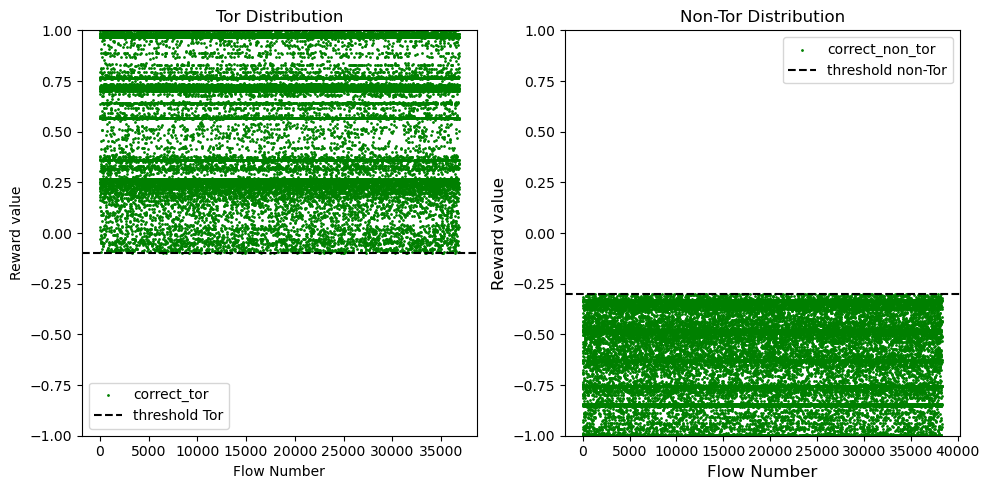

In [125]:
normal=[]
tor=[]
out_normal=[]
out_tor=[]
yes=0
item="recur"
ambiguous_tensors=[]
y=alllabel_np_og
batch_size=128
threshold_tor=-0.1
threshold_non_tor=-0.3
y_limit_low=-1
y_limit_hi=1
'''
X=feature_lo_df

X_test_recur = X.filter([calc_result_recur[s][0] for s in range(num_feature)], axis=1)
X_test_RFECV = X.filter([calc_result_RFECV[s][0] for s in range(num_feature)], axis=1)
X_test_kbest = X.filter([calc_result_kbest[s][0] for s in range(num_feature)], axis=1)
X_test_rf = X.filter([calc_result_rf[s][0] for s in range(num_feature)], axis=1)'''

start_time = time.time()
scaler = StandardScaler()
X_test_recur=scaler.fit_transform(X_test_recur)
X_test_RFECV=scaler.fit_transform(X_test_RFECV)
X_test_kbest=scaler.fit_transform(X_test_kbest)
X_test_rf=scaler.fit_transform(X_test_rf)

test_feature_recur = torch.tensor(X_test_recur)
test_feature_RFECV = torch.tensor(X_test_RFECV)
test_feature_rf = torch.tensor(X_test_rf)
test_feature_kbest = torch.tensor(X_test_kbest)

test_label = torch.tensor(y)

#test_indices = np.where(np.isin(recur_scaled, X_test))

new_para = [x for x in para_list if x != item]

# start counting time
start_time = time.time()

with torch.no_grad():
    for i in range(0, len(test_feature_recur), batch_size):
        r=[]
        r_RFECV=[]
        r_rf=[]
        r_kbest=[]
        batch_features = test_feature_recur[i:i + batch_size].to(torch.float32)
        batch_features_RFECV = test_feature_RFECV[i:i + batch_size].to(torch.float32)
        batch_features_rf = test_feature_rf[i:i + batch_size].to(torch.float32)
        batch_features_kbest = test_feature_kbest[i:i + batch_size].to(torch.float32)
        batch_labels = test_label[i:i + batch_size]
        
        
        #if (item=="recur"):
        r = model_recur(batch_features).detach().numpy()
        r_RFECV = model_RFECV(batch_features_RFECV).detach().numpy()
        r_rf = model_rf(batch_features_rf).detach().numpy()
        r_kbest = model_kbest(batch_features_kbest).detach().numpy()

        for j in range(len(batch_labels)):
            prediction = r[j]
            label = batch_labels[j]

            if (prediction >= threshold_tor):
                if (label == 1):
                    tor.append(prediction)
                    yes += 1
                else:
                    out_tor.append(prediction)

            elif (prediction <= threshold_non_tor):
                if (label == -1):
                    normal.append(prediction)
                    yes += 1
                else:
                    out_normal.append(prediction)
            
            else:
                
                for index, k in enumerate(new_para):
                    
                    if (k == "kbest"):
                        if (r_kbest[j] >= threshold_tor):
                            if (label == 1):
                                tor.append(r_kbest[j])
                                yes += 1
                            else:
                                out_tor.append(r_kbest[j])
                            break
                        
                        if (r_kbest[j] <= threshold_non_tor):
                            if (label == -1):
                                normal.append(r_kbest[j])
                                yes += 1
                            else:
                                out_normal.append(r_kbest[j])
                            break
                    
                    elif (k == "RFECV"):
                        if (r_RFECV[j] >= threshold_tor):
                            if (label == 1):
                                tor.append(r_RFECV[j])
                                yes += 1
                            else:
                                out_tor.append(r_RFECV[j])
                            break
                        
                        elif (r_RFECV[j] <= threshold_non_tor):
                            if (label == -1):
                                normal.append(r_RFECV[j])
                                yes += 1
                            else:
                                out_normal.append(r_RFECV[j])
                            break
                    
                    elif (k == "rf"):
                        if (r_rf[j] >= threshold_tor):
                            if (label == 1):
                                tor.append(r_rf[j])
                                yes += 1
                            else:
                                out_tor.append(r_rf[j])
                            break
                        
                        elif (r_rf[j] <= threshold_non_tor):
                            if (label == -1):
                                normal.append(r_rf[j])
                                yes += 1
                            else:
                                out_normal.append(r_rf[j])
                            break
                    
                    
                    
                    if (k=="kbest"):
                        
                        ambiguous_tensors.append(prediction)
                        
                
    end_time = time.time()

    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time 
    print(f"Elapsed time: {elapsed_time:.3f} seconds")
    
    #ambiguous = torch.stack(ambiguous_tensors)
    #a_labels = torch.stack(ambiguous_labels)
    
fig, axes=plt.subplots(nrows=1, ncols=2,figsize=(10, 5), tight_layout=True)
x = np.arange(0, len(tor), 1) # Tor above 0.5
#xx=np.arange(0, len(ambiguous), 1)
axes[0].scatter(x, tor, s=1, color='green', marker='o', label="correct_tor")
#axes[0][0].scatter(xx, ambiguous, s=1, color='orange', marker='o', label="ambiguous samples")
axes[0].set_xlabel('Flow Number')
axes[0].set_ylabel('Reward value')
axes[0].set_ylim(y_limit_low,y_limit_hi)
l1=axes[0].axhline(threshold_tor,color='black',ls='--')
l1.set_label('threshold Tor')
axes[0].set_title('Tor Distribution')
axes[0].legend(loc='best')

'''x = np.arange(0, len(out_tor), 1) # Tor below 0.5
axes[0][1].scatter(x, out_tor, s=1, color='red', marker='o', label="wrong_tor")
axes[0][1].set_xlabel('Flow Number')
axes[0][1].set_ylabel('Reward value')
axes[0][1].set_ylim(y_limit_low, y_limit_hi)
l2=axes[0][1].axhline(threshold_tor,color='black',ls='--')
l2.set_label('threshold Tor')
axes[0][1].set_title('Non-Tor Sample Above Threshold-Tor ')
axes[0][1].legend(loc='best')'''


x = np.arange(0, len(normal), 1) # non-Tor
axes[1].scatter(x, normal, s=1, color='green', marker='o', label="correct_non_tor")
#xx=np.arange(0, len(ambiguous), 1)
#axes[1][0].scatter(x, ambiguous, s=1, color='orange', marker='o', label="ambiguous samples")
axes[1].set_xlabel('Flow Number', fontsize=12)
axes[1].set_ylabel('Reward value', fontsize=12)
axes[1].set_ylim(y_limit_low, y_limit_hi)
l2=axes[1].axhline(threshold_non_tor,color='black',ls='--')
l2.set_label('threshold non-Tor')
axes[1].set_title('Non-Tor Distribution')
axes[1].legend(loc='best')


'''x = np.arange(0, len(out_normal), 1) # non-Tor
axes[1][1].scatter(x, out_normal, s=1, color='red', marker='o', label="wrong_non-tor")
axes[1][1].set_xlabel('Flow Number')
axes[1][1].set_ylabel('Reward value')
axes[1][1].set_ylim(y_limit_low, y_limit_hi)
l4=axes[1][1].axhline(threshold_non_tor,color='black',ls='--')
l4.set_label('threshold non-Tor')
axes[1][1].set_title('Tor Distribution Below Non-Tor Threshold')
axes[1][1].legend(loc='best')'''
fig.savefig("final" + "_threshold.pdf", format="pdf", bbox_inches="tight")

myarr=test_label.detach().numpy()

you="youtest"
filename = f'{you}.txt'
with open(filename, 'w') as file:
    file.write(item +" normal accuracy: "+ str(len(normal)/np.count_nonzero(myarr == -1)) + '\n')
    file.write(item + " Tor accuracy: " + str(len(tor)/np.count_nonzero(myarr == 1))+'\n')
    file.write(item + " total accuracy: " + str(yes/len(test_feature_recur))+'\n')

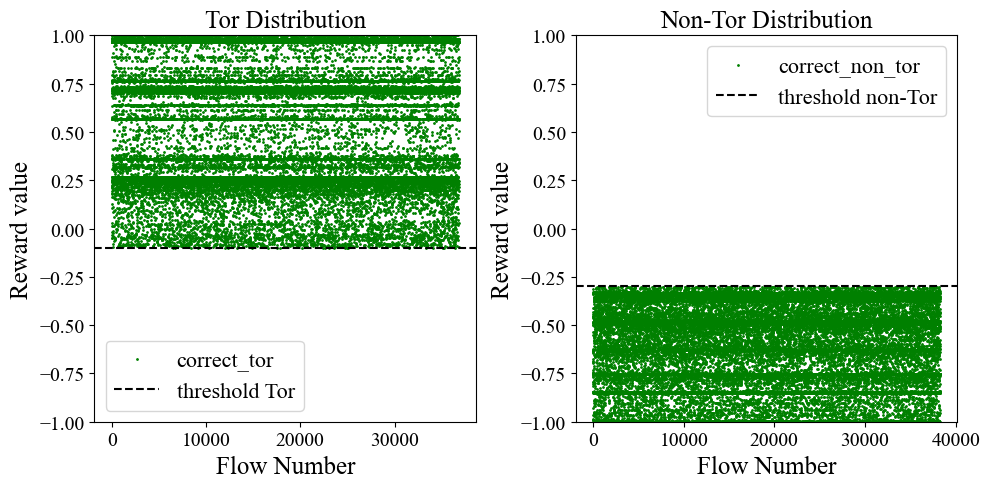

In [146]:
fig, axes=plt.subplots(nrows=1, ncols=2,figsize=(10, 5), tight_layout=True)
plt.rcParams["font.family"] = "Times New Roman"
x = np.arange(0, len(tor), 1) # Tor above 0.5
#xx=np.arange(0, len(ambiguous), 1)
axes[0].scatter(x, tor, s=1, color='green', marker='o', label="correct_tor")
#axes[0][0].scatter(xx, ambiguous, s=1, color='orange', marker='o', label="ambiguous samples")
axes[0].set_xlabel('Flow Number', fontsize=18)
axes[0].set_ylabel('Reward value', fontsize=18)
axes[0].set_ylim(y_limit_low,y_limit_hi)
l1=axes[0].axhline(threshold_tor,color='black',ls='--')
l1.set_label('threshold Tor')
axes[0].set_title('Tor Distribution', fontsize=18)
axes[0].legend(loc='best', fontsize=16)
axes[0].tick_params(axis='x', labelsize=14)  # Adjust font size for x-axis numbers
axes[0].tick_params(axis='y', labelsize=14)  # Adjust font size for y-axis numbers


x = np.arange(0, len(normal), 1) # non-Tor
axes[1].scatter(x, normal, s=1, color='green', marker='o', label="correct_non_tor")
#xx=np.arange(0, len(ambiguous), 1)
#axes[1][0].scatter(x, ambiguous, s=1, color='orange', marker='o', label="ambiguous samples")
axes[1].set_xlabel('Flow Number', fontsize=18)
axes[1].set_ylabel('Reward value', fontsize=18)
axes[1].set_ylim(y_limit_low, y_limit_hi)
l2=axes[1].axhline(threshold_non_tor,color='black',ls='--')
l2.set_label('threshold non-Tor')
axes[1].set_title('Non-Tor Distribution', fontsize=18)
axes[1].legend(loc='best', fontsize=16)
axes[1].tick_params(axis='x', labelsize=14)  # Adjust font size for x-axis numbers
axes[1].tick_params(axis='y', labelsize=14)  # Adjust font size for y-axis numbers



fig.savefig("final" + "_threshold.pdf", format="pdf", bbox_inches="tight")

myarr=test_label.detach().numpy()

you="youtest"
filename = f'{you}.txt'
with open(filename, 'w') as file:
    file.write(item +" normal accuracy: "+ str(len(normal)/np.count_nonzero(myarr == -1)) + '\n')
    file.write(item + " Tor accuracy: " + str(len(tor)/np.count_nonzero(myarr == 1))+'\n')
    file.write(item + " total accuracy: " + str(yes/len(test_feature_recur))+'\n')

In [37]:
my_acc=[]
tor_thre=[]
count=1
non_tor_thre=[]
for i in np.arange(0, 1, 0.05):
    threshold_tor=i
    threshold_non_tor=-i
    normal=[]
    tor=[]
    out_normal=[]
    out_tor=[]
    yes=0
    item="recur"
    ambiguous_tensors=[]
    y=alllabel_np_og
    batch_size=128

    y_limit_low=-1
    y_limit_hi=1

    start_time = time.time()
    scaler = StandardScaler()
    X_test_recur=scaler.fit_transform(X_test_recur)
    X_test_RFECV=scaler.fit_transform(X_test_RFECV)
    X_test_kbest=scaler.fit_transform(X_test_kbest)
    X_test_rf=scaler.fit_transform(X_test_rf)

    test_feature_recur = torch.tensor(X_test_recur)
    test_feature_RFECV = torch.tensor(X_test_RFECV)
    test_feature_rf = torch.tensor(X_test_rf)
    test_feature_kbest = torch.tensor(X_test_kbest)

    test_label = torch.tensor(y)

    #test_indices = np.where(np.isin(recur_scaled, X_test))

    new_para = [x for x in para_list if x != item]

    # start counting time
    start_time = time.time()

    with torch.no_grad():
        for i in range(0, len(test_feature_recur), batch_size):
            r=[]
            r_RFECV=[]
            r_rf=[]
            r_kbest=[]
            batch_features = test_feature_recur[i:i + batch_size].to(torch.float32)
            batch_features_RFECV = test_feature_RFECV[i:i + batch_size].to(torch.float32)
            batch_features_rf = test_feature_rf[i:i + batch_size].to(torch.float32)
            batch_features_kbest = test_feature_kbest[i:i + batch_size].to(torch.float32)
            batch_labels = test_label[i:i + batch_size]


            #if (item=="recur"):
            r = model_recur(batch_features).detach().numpy()
            r_RFECV = model_RFECV(batch_features_RFECV).detach().numpy()
            r_rf = model_rf(batch_features_rf).detach().numpy()
            r_kbest = model_kbest(batch_features_kbest).detach().numpy()

            for j in range(len(batch_labels)):
                prediction = r[j]
                label = batch_labels[j]

                if (prediction >= threshold_tor):
                    if (label == 1):
                        tor.append(prediction)
                        yes += 1
                    else:
                        out_tor.append(prediction)

                elif (prediction <= threshold_non_tor):
                    if (label == -1):
                        normal.append(prediction)
                        yes += 1
                    else:
                        out_normal.append(prediction)

                else:

                    for index, k in enumerate(new_para):

                        if (k == "kbest"):
                            if (r_kbest[j] >= threshold_tor):
                                if (label == 1):
                                    tor.append(r_kbest[j])
                                    yes += 1
                                else:
                                    out_tor.append(r_kbest[j])
                                break

                            if (r_kbest[j] <= threshold_non_tor):
                                if (label == -1):
                                    normal.append(r_kbest[j])
                                    yes += 1
                                else:
                                    out_normal.append(r_kbest[j])
                                break

                        elif (k == "RFECV"):
                            if (r_RFECV[j] >= threshold_tor):
                                if (label == 1):
                                    tor.append(r_RFECV[j])
                                    yes += 1
                                else:
                                    out_tor.append(r_RFECV[j])
                                break

                            elif (r_RFECV[j] <= threshold_non_tor):
                                if (label == -1):
                                    normal.append(r_RFECV[j])
                                    yes += 1
                                else:
                                    out_normal.append(r_RFECV[j])
                                break

                        elif (k == "rf"):
                            if (r_rf[j] >= threshold_tor):
                                if (label == 1):
                                    tor.append(r_rf[j])
                                    yes += 1
                                else:
                                    out_tor.append(r_rf[j])
                                break

                            elif (r_rf[j] <= threshold_non_tor):
                                if (label == -1):
                                    normal.append(r_rf[j])
                                    yes += 1
                                else:
                                    out_normal.append(r_rf[j])
                                break



                        if (k=="kbest"):

                            ambiguous_tensors.append(prediction)       
        end_time = time.time()
        # Calculate and print the elapsed time
        elapsed_time = end_time - start_time 
        print(count, f"Elapsed time: {elapsed_time:.3f} seconds")

    myarr=test_label.detach().numpy()

    my_acc.append(yes/len(test_feature_recur))
    tor_thre.append(threshold_tor)
    non_tor_thre.append(threshold_non_tor)
    count+=1

1 Elapsed time: 0.995 seconds
2 Elapsed time: 1.028 seconds
3 Elapsed time: 0.971 seconds
4 Elapsed time: 0.976 seconds
5 Elapsed time: 1.012 seconds
6 Elapsed time: 1.052 seconds
7 Elapsed time: 1.072 seconds
8 Elapsed time: 1.063 seconds
9 Elapsed time: 1.101 seconds
10 Elapsed time: 1.089 seconds
11 Elapsed time: 1.096 seconds
12 Elapsed time: 1.146 seconds
13 Elapsed time: 1.117 seconds
14 Elapsed time: 1.149 seconds
15 Elapsed time: 1.129 seconds
16 Elapsed time: 1.155 seconds
17 Elapsed time: 1.188 seconds
18 Elapsed time: 1.192 seconds
19 Elapsed time: 1.187 seconds
20 Elapsed time: 1.192 seconds


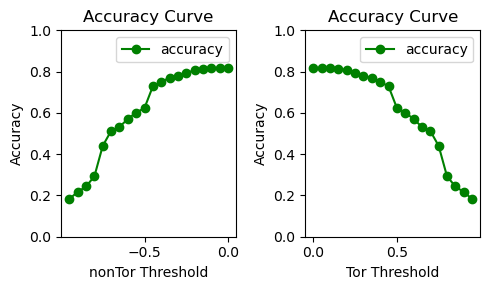

In [38]:
fig, axes=plt.subplots(nrows=1, ncols=2,figsize=(5, 3), tight_layout=True)

axes[1].plot(tor_thre, my_acc, color='green', marker='o', label="accuracy")
axes[1].set_xlabel('Tor Threshold')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1)
axes[1].set_title('Accuracy Curve')
axes[1].legend(loc='best')

axes[0].plot(non_tor_thre, my_acc, color='green', marker='o', label="accuracy")
#axes[0][0].scatter(xx, ambiguous, s=1, color='orange', marker='o', label="ambiguous samples")
axes[0].set_xlabel('nonTor Threshold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0,1)
axes[0].set_title('Accuracy Curve')
axes[0].legend(loc='best')

fig.savefig('haha.pdf', format='pdf')

In [71]:
ambiguous=[]
acc_tor_r=[]
acc_nontor_r=[]
acc_all_r=[]
for i in range(21):
    normal=[]
    tor=[]
    out_normal=[]
    out_tor=[]
    yes=0
    item="recur"
    ambiguous_tensors=[]
    y=alllabel_np_og
    batch_size=128
    threshold_tor = -0.05*i
    threshold_non_tor= 0.05*i
    y_limit_low=-1
    y_limit_hi=1
    '''
    X=feature_lo_df

    X_test_recur = X.filter([calc_result_recur[s][0] for s in range(num_feature)], axis=1)
    X_test_RFECV = X.filter([calc_result_RFECV[s][0] for s in range(num_feature)], axis=1)
    X_test_kbest = X.filter([calc_result_kbest[s][0] for s in range(num_feature)], axis=1)
    X_test_rf = X.filter([calc_result_rf[s][0] for s in range(num_feature)], axis=1)'''

    start_time = time.time()
    scaler = StandardScaler()
    X_test_recur=scaler.fit_transform(X_test_recur)
    X_test_RFECV=scaler.fit_transform(X_test_RFECV)
    X_test_kbest=scaler.fit_transform(X_test_kbest)
    X_test_rf=scaler.fit_transform(X_test_rf)

    test_feature_recur = torch.tensor(X_test_recur)
    test_feature_RFECV = torch.tensor(X_test_RFECV)
    test_feature_rf = torch.tensor(X_test_rf)
    test_feature_kbest = torch.tensor(X_test_kbest)

    test_label = torch.tensor(y)

    #test_indices = np.where(np.isin(recur_scaled, X_test))

    new_para = [x for x in para_list if x != item]

    # start counting time
    start_time = time.time()

    with torch.no_grad():
        for i in range(0, len(test_feature_recur), batch_size):
            r=[]
            r_RFECV=[]
            r_rf=[]
            r_kbest=[]
            batch_features = test_feature_recur[i:i + batch_size].to(torch.float32)
            batch_features_RFECV = test_feature_RFECV[i:i + batch_size].to(torch.float32)
            batch_features_rf = test_feature_rf[i:i + batch_size].to(torch.float32)
            batch_features_kbest = test_feature_kbest[i:i + batch_size].to(torch.float32)
            batch_labels = test_label[i:i + batch_size]


            #if (item=="recur"):
            r = model_recur(batch_features).detach().numpy()
            r_RFECV = model_RFECV(batch_features_RFECV).detach().numpy()
            r_rf = model_rf(batch_features_rf).detach().numpy()
            r_kbest = model_kbest(batch_features_kbest).detach().numpy()

            for j in range(len(batch_labels)):
                prediction = r[j]
                label = batch_labels[j]

                if (prediction >= threshold_tor):
                    if (label == 1):
                        tor.append(prediction)
                        yes += 1
                    else:
                        out_tor.append(prediction)

                elif (prediction <= threshold_non_tor):
                    if (label == -1):
                        normal.append(prediction)
                        yes += 1
                    else:
                        out_normal.append(prediction)

                else:

                    for index, k in enumerate(new_para):

                        if (k == "kbest"):
                            if (r_kbest[j] >= threshold_tor):
                                if (label == 1):
                                    tor.append(r_kbest[j])
                                    yes += 1
                                else:
                                    out_tor.append(r_kbest[j])
                                break

                            if (r_kbest[j] <= threshold_non_tor):
                                if (label == -1):
                                    normal.append(r_kbest[j])
                                    yes += 1
                                else:
                                    out_normal.append(r_kbest[j])
                                break

                        elif (k == "RFECV"):
                            if (r_RFECV[j] >= threshold_tor):
                                if (label == 1):
                                    tor.append(r_RFECV[j])
                                    yes += 1
                                else:
                                    out_tor.append(r_RFECV[j])
                                break

                            if (r_RFECV[j] <= threshold_non_tor):
                                if (label == -1):
                                    normal.append(r_RFECV[j])
                                    yes += 1
                                else:
                                    out_normal.append(r_RFECV[j])
                                break

                        elif (k == "rf"):
                            if (r_rf[j] >= threshold_tor):
                                if (label == 1):
                                    tor.append(r_rf[j])
                                    yes += 1
                                else:
                                    out_tor.append(r_rf[j])
                                break

                            if (r_rf[j] <= threshold_non_tor):
                                if (label == -1):
                                    normal.append(r_rf[j])
                                    yes += 1
                                else:
                                    out_normal.append(r_rf[j])
                                break


                        
                        if (k=="kbest"):
                            
                            ambiguous_tensors.append(prediction)


        end_time = time.time()

        # Calculate and print the elapsed time
        elapsed_time = end_time - start_time 
        print(f"Elapsed time: {elapsed_time:.3f} seconds")

        #ambiguous = torch.stack(ambiguous_tensors)
        #a_labels = torch.stack(ambiguous_labels)


    myarr=test_label.detach().numpy()
    ambiguous.append(len(ambiguous_tensors))
    you="youtest"
    filename = f'{you}.txt'
    with open(filename, "a", newline="") as file:
        file.write(item + str(threshold_tor) + str(threshold_non_tor) + '\n')
        file.write(item +" normal accuracy: "+ str(len(normal)/np.count_nonzero(myarr == -1)) + '\n')
        file.write(item + " Tor accuracy: " + str(len(tor)/np.count_nonzero(myarr == 1))+'\n')
        file.write(item + " total accuracy: " + str(yes/len(test_feature_recur))+'\n')
        file.write('\n')
    acc_tor_r.append(len(tor)/np.count_nonzero(myarr == 1))
    acc_nontor_r.append(len(normal)/np.count_nonzero(myarr == -1))
    acc_all_r.append(yes/len(test_feature_recur))


Elapsed time: 0.982 seconds
Elapsed time: 0.958 seconds
Elapsed time: 0.953 seconds
Elapsed time: 0.946 seconds
Elapsed time: 0.951 seconds
Elapsed time: 0.991 seconds
Elapsed time: 0.962 seconds
Elapsed time: 0.945 seconds
Elapsed time: 0.968 seconds
Elapsed time: 0.934 seconds
Elapsed time: 0.980 seconds
Elapsed time: 0.968 seconds
Elapsed time: 0.964 seconds
Elapsed time: 0.943 seconds
Elapsed time: 0.915 seconds
Elapsed time: 0.933 seconds
Elapsed time: 0.912 seconds
Elapsed time: 0.911 seconds
Elapsed time: 0.915 seconds
Elapsed time: 0.901 seconds
Elapsed time: 0.995 seconds


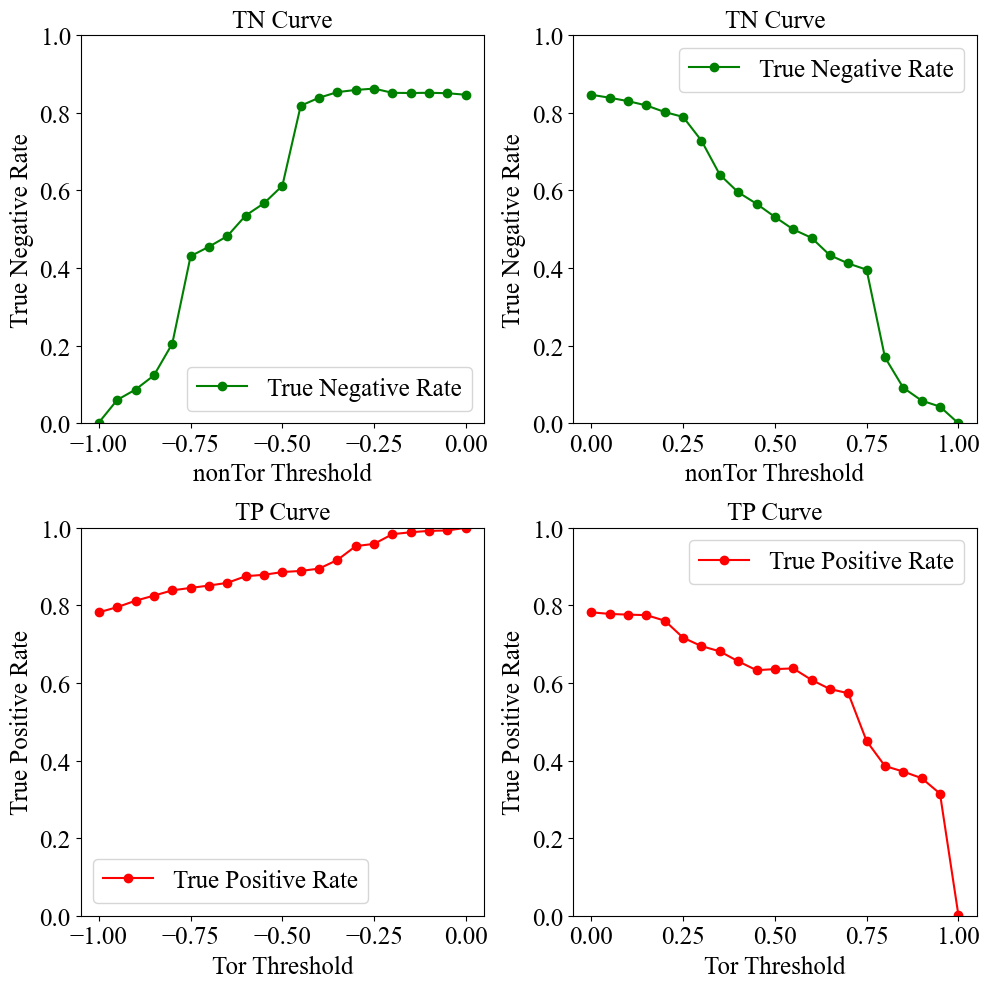

In [138]:
fig, axes=plt.subplots(nrows=2, ncols=2,figsize=(10, 10), tight_layout=True)
plt.rcParams["font.family"] = "Times New Roman"

x = np.arange(-1, 0.05, 0.05)[::-1]
axes[0][0].plot(x, acc_nontor, color='green', marker='o', label="True Negative Rate")
#axes[0][0].scatter(xx, ambiguous, s=1, color='orange', marker='o', label="ambiguous samples")
axes[0][0].set_xlabel('nonTor Threshold', fontsize=18)
axes[0][0].set_ylabel('True Negative Rate', fontsize=18)
axes[0][0].set_ylim(0,1)
axes[0][0].set_title('TN Curve', fontsize=18)
axes[0][0].legend(loc='best', fontsize=18)
axes[0][0].tick_params(axis='x', labelsize=18)  # Adjust font size for x-axis numbers
axes[0][0].tick_params(axis='y', labelsize=18)  # Adjust font size for y-axis numbers

x=np.arange(0,1.05,0.05)
axes[0][1].plot(x, acc_nontor_r, color='green', marker='o', label="True Negative Rate")
axes[0][1].set_xlabel('nonTor Threshold', fontsize=18)
axes[0][1].set_ylabel('True Negative Rate', fontsize=18)
axes[0][1].set_ylim(0, 1)
axes[0][1].set_title('TN Curve', fontsize=18)
axes[0][1].legend(loc='best', fontsize=18)
axes[0][1].tick_params(axis='x', labelsize=18)  # Adjust font size for x-axis numbers
axes[0][1].tick_params(axis='y', labelsize=18)  # Adjust font size for y-axis numbers


x = np.arange(0,1.05,0.05)
axes[1][1].plot(x, acc_tor, color='red', marker='o', label="True Positive Rate")
axes[1][1].set_xlabel('Tor Threshold', fontsize=18)
axes[1][1].set_ylabel('True Positive Rate', fontsize=18)
axes[1][1].set_ylim(0, 1)
axes[1][1].set_title('TP Curve', fontsize=18)
axes[1][1].legend(loc='best', fontsize=18)
axes[1][1].tick_params(axis='x', labelsize=18)  # Adjust font size for x-axis numbers
axes[1][1].tick_params(axis='y', labelsize=18)  # Adjust font size for y-axis numbers


x = np.arange(-1,0.05, 0.05)
axes[1][0].plot(x, acc_tor_r, color='red', marker='o', label="True Positive Rate")
axes[1][0].set_xlabel('Tor Threshold', fontsize=18)
axes[1][0].set_ylabel('True Positive Rate', fontsize=18)
axes[1][0].set_ylim(0, 1)
axes[1][0].set_title('TP Curve', fontsize=18)
axes[1][0].legend(loc='best', fontsize=18)
axes[1][0].tick_params(axis='x', labelsize=18)  # Adjust font size for x-axis numbers
axes[1][0].tick_params(axis='y', labelsize=18)  # Adjust font size for y-axis numbers
fig.savefig("myImagePDF.pdf", format="pdf", bbox_inches="tight")

In [ ]:
'''Action space: Feature sets selected by: [recursive elimination, k best, Random Forest, recfv], reduce feature set to 3.

State space: [Tor, non-Tor, Ambiguous], [t1, t2, t3]

Reward: sigmoid function sigmoid(w1f1+w2f2)


P(s'|s,r) -> P(s'|s,a) at Non-Tor 
Transition: P(s’,r|s,a) Given non-Tor, select recursive elimination/k best/Random Forest, what is the next state
'''

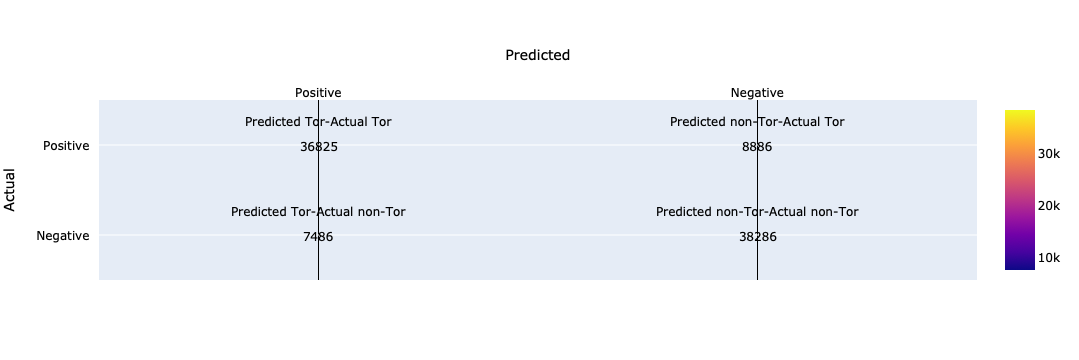

In [109]:
cmtx=[[36825,8886],
     [7486, 38286]]

fig = ff.create_annotated_heatmap(z=cmtx, x=["Positive", "Negative"], 
                                  y=["Positive", "Negative"],showscale=True,font_colors=['black', 'black'])
fig.update_layout(font=dict(color="black",size=12))
# Add Labels
fig.add_annotation(x=0,y=0, text="Predicted Tor-Actual Tor", yshift=25, showarrow=False, font=dict(color="black",size=12))
fig.add_annotation(x=1,y=0, text="Predicted non-Tor-Actual Tor", yshift=25, showarrow=False, font=dict(color="black",size=12))
fig.add_annotation(x=0,y=1, text="Predicted Tor-Actual non-Tor", yshift=25, showarrow=False, font=dict(color="black",size=12))
fig.add_annotation(x=1,y=1, text="Predicted non-Tor-Actual non-Tor", yshift=25, showarrow=False, font=dict(color="black",size=12))

fig.update_xaxes(title="Predicted")
fig.update_yaxes(title="Actual", autorange="reversed")


In [98]:
pio.write_image(fig, "confusion_matrixx.pdf")
#pip install -U kaleido

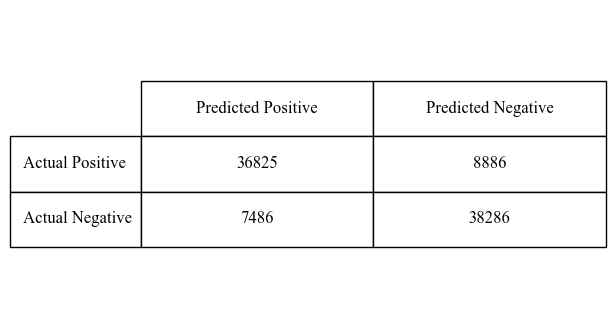

In [133]:
cmtx = np.array([[36825, 8886], [7486, 38286]])

fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams["font.family"] = "Times New Roman"

ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=cmtx, colLabels=["Predicted Positive", "Predicted Negative"], 
                     rowLabels=["Actual Positive", "Actual Negative"], loc='center', 
                     cellLoc='center')

# Adjust cell height
table_props = the_table.properties()
table_cells = table_props['children']
for cell in table_cells:
    cell.set_height(0.18)  # adjust this value as needed
    cell.set_fontsize(12)

plt.show()
fig.savefig("confusion.pdf", format="pdf", bbox_inches="tight")

In [16]:
scaled = standardize_preprocessing(feature_lo_df.values)
X_train, X_test, y_train, y_test = train_test_split(scaled, alllabel_np_og, test_size = 0.3, random_state=42)
myrf = RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=10, n_estimators=125)
myrf.fit(X_train, y_train)
calc_result_rf = list(zip(feature_lo_df, myrf.feature_importances_))
calc_result_rf.sort(key = lambda x : x[1], reverse=True)

In [20]:
myfp=[]
mytp=[]
mytn=[]
myfn=[]
acc_buffer=[]
for i in range (0, 45, 15):
    filtered_df = feature_lo_df.filter([calc_result_rf[s][0] for s in range(0, i+15)], axis=1)
    scaled = standardize_preprocessing(filtered_df.values)
    X_train, X_test, y_train, y_test = train_test_split(scaled, alllabel_np_og, test_size = 0.3, random_state=42)
    myrf = RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=10, n_estimators=125)
    myrf.fit(X_train, y_train)
    y_pred = myrf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    myfp.append(fp)
    mytp.append(tp)
    mytn.append(tn)
    myfn.append(fn)
    acc_buffer.append(accuracy)

In [18]:
print(myfp)
print(mytp)
print(mytn)
print(myfn)

[349, 295, 298]
[12870, 12955, 12963]
[13764, 13818, 13815]
[462, 377, 369]


In [15]:
acc_buffer

[0.975660411732556]

In [21]:
filtered_df = feature_lo_df.filter([calc_result_rf[s][0] for s in range(58)], axis=1)
scaled = standardize_preprocessing(filtered_df.values)
X_train, X_test, y_train, y_test = train_test_split(scaled, alllabel_np_og, test_size = 0.3, random_state=42)
myrf = RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=10, n_estimators=125)
myrf.fit(X_train, y_train)

y_pred = myrf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
acc_buffer.append(accuracy)

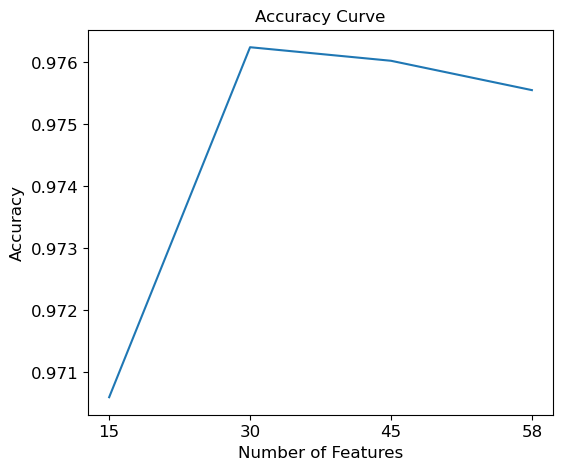

In [56]:
# Create an array of indices
indices = np.arange(len(acc_buffer))
custom_labels = ['15', '30', '45', '58']
# Plot the array
fig99=plt.figure(figsize=(6, 5))
plt.plot(indices, acc_buffer)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curve', fontsize=12)
plt.xticks(indices, labels=custom_labels, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [57]:
fig99.savefig('num_features.pdf', format='pdf')